# 13 目标检测基础

在前面的章节里，我们学习了图像分类的方法。设想一下，当我们将计算机视觉技术应用于自动驾驶汽车时，我们不仅需要识别道路图像中是否包含车辆、人行道和行人的图像，还需要精确地定位这些物体的位置。在接下来的部分中，我们将学习目标检测基础，即对图像中的目标进行分类，并定位其在图像中的坐标位置。

接下来，我们将开始学习目标检测的基础，包括：
1. 如何标记边界框（标注数据）用于模型训练
2. 理解什么是候选区域，以及使用SelectiveSearch方法，生成候选区域
3. 理解交并比（IoU），非极大值抑制（non-max suppression），均值平均准确率（Mean Average Precision，MAP）
4. 基于R-CNN的目标分类模型

## 13.1 目标分类简介

随着自动驾驶汽车、面部检测、智能视频监控和人数统计解决方案的兴起，对快速且准确目标检测系统的需求日益增长。这些系统不仅包括从图像中进行目标分类，还包括定位每个目标的位置，通过在它们周围绘制适当的边界框。目标检测比图像分类更为复杂。<br>
在我们学习目标检测之前，先让我们理解它如何扩展我们在之前课程学习的目标分类任务。设想一下，有一张包含多个物体的图像。现在我们要识别图像中所有物体的类别。比如，假设这张图像中既有猫也有狗。面对这样的图像，如何进行分类？这时，目标检测的优势就显现出来了，它不仅能预测图像中物体的位置（通过绘制边界框），还能识别每个边界框内物体的具体类别。<br>
为了理解目标检测的输出是什么样子，让我们看一下下面的图表：

图1<br>
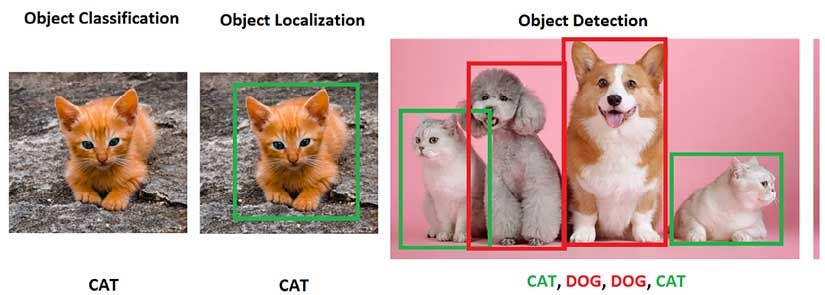

根据上图我们可以看到，目标分类只需要返回图像所包含的类别，而目标定位需要返回图像所包含的类别，并在图像中相应的物体周围绘制一个边界框，目标检测则需要给出图像中所有出现的物体的分类，并且在其周围绘制边界框。

目标检测通常被应用于：
1. 安全：入侵识别
2. 自动驾驶：识别道路中的各种目标
3. 图像搜索：识别图像中包含的对象
4. 识别图像中的车牌号码等等

要训练一个模型，能准确预测目标的分类，并绘制准确紧密的边界框，我们需要：
1. 创建标注数据：标注图像中各个对象的类别标签和边界框，用于模型训练。
2. 设计一种能识别出可能包含目标的区域的机制。
3. 使用交并比（IoU）指标来创建目标类别变量
4. 创建目标边界框偏移量变量，以对第2步中的候选区域位置进行校正
5. 构建一个模型，能够预测物体的类别以及与候选区域相对应的目标边界框偏移量
6. 使用平均精度均值（mAP）来衡量目标检测的准确性

## 13.2 标注图像边界框（bounding-box ground truth）用于模型训练

链接<br>
在此链接下载ybat-master.zip文件，并解压。<br>
该项目的GitHub地址：https://github.com/drainingsun/ybat

将我们要分类的类别保存到一个文本文件classes.txt中，每行一个类别，如图2所示<br>
打开刚刚解压的文件夹中的ybat.html文件

图2<br>
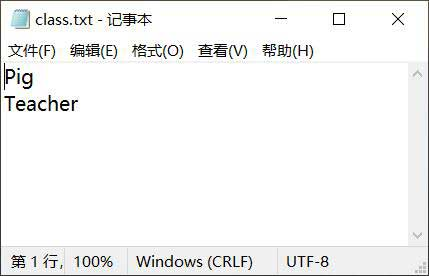

1. 上传我们要标注的图像文件，如图所示
2. 上传classes.txt文件
3. 选择要标注的图片文件和类别，绘制边界框
4. 将数据转储保存在所需的格式中。每种格式都是由不同的研究团队独立开发的，并且都是同样有效的。根据它们的流行度和便利性，每种实现都倾向于使用不同的格式。

上面4个步骤如下图所示：

图3<br>
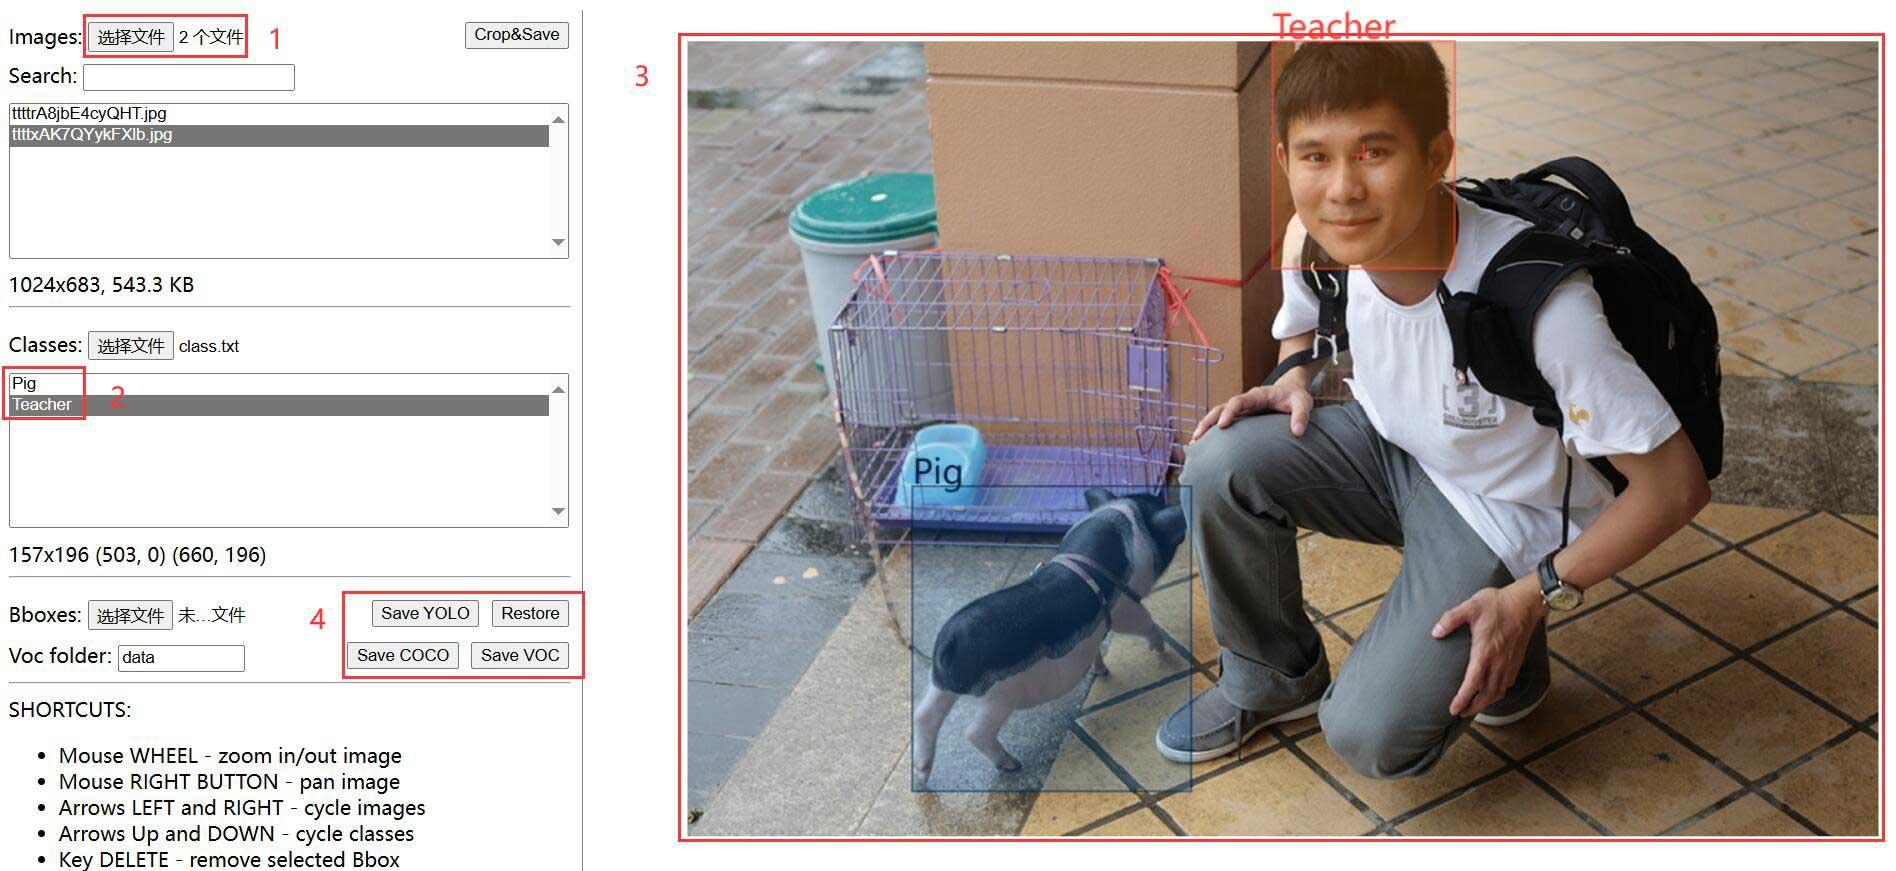
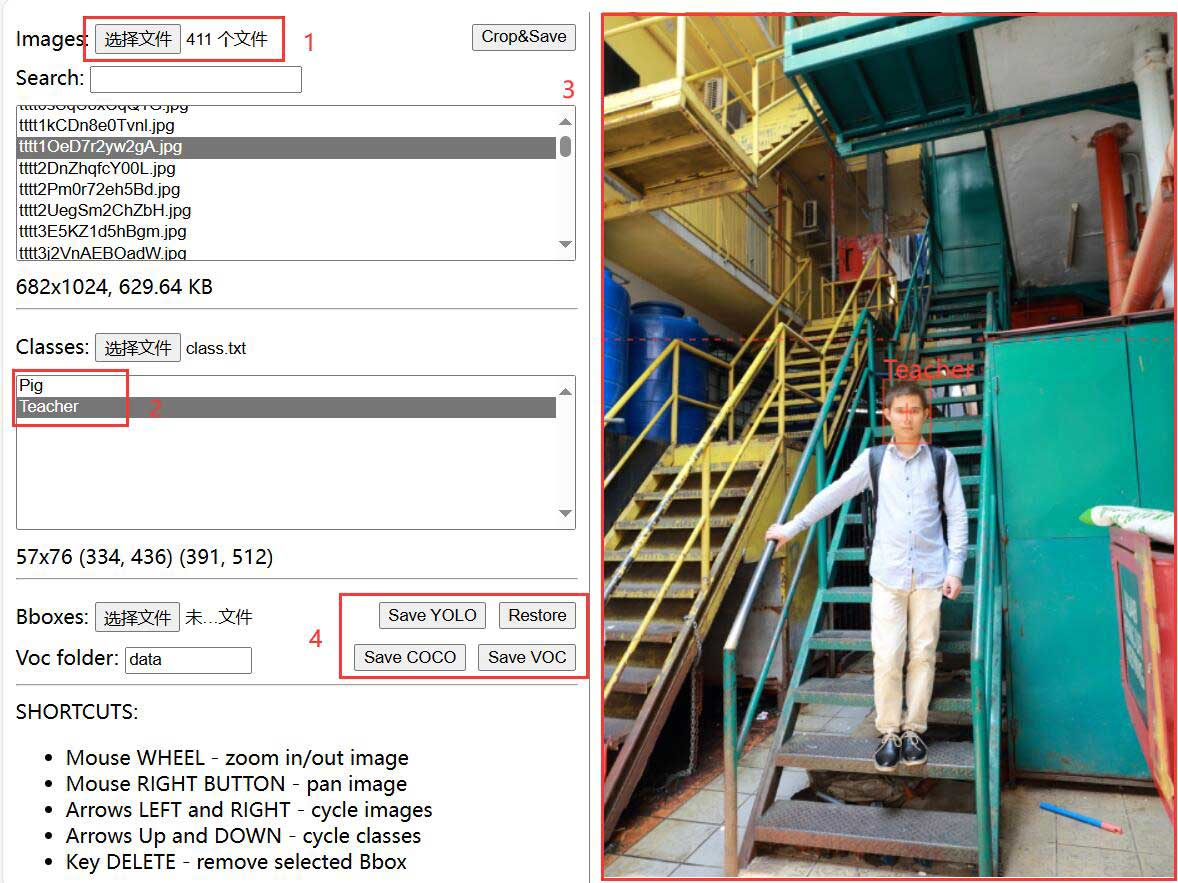

## 13.3 候选区域

想象这样一个场景，图像中包含了一个人和背景中的天空。假设背景（天空）的像素强度变化很小，而前景（人物）的像素强度变化很大。<br>
仅从前面的描述中，我们可以得出这里有两个主要区域——人物和天空。此外，在人物图像区域内，对应头发的像素与对应脸部的像素强度不同，这表明一个区域内可以有多个子区域。<br>
区域提议是一种帮助识别像素彼此相似的区域的技术。生成区域提议对于目标检测非常有用，我们要识别图像中物体的位置。此外，区域提议是一个生成候选区域的提议，它会生成很多可能包含目标对象的区域（也可能不包含），我们会对这些区域进度对象分类，并将这些候选边界框根据对应目标的真实边界框进行调整（偏移量）。

### 13.3.1 使用SelectiveSearch生成候选区域

SelectiveSearch是一种生成候选区域的算法，它基于像素强度生成可能包含对象的候选区域。<br>SelectiveSearch通过层次化的相似像素分组，利用图像内容的颜色、纹理、大小和形状来对像素进行分组。<br>
SelectiveSearch先通过基于前述属性对图像进行过分割，然后，它遍历这些过分割的组，并根据相似性将它们分组。在每次迭代中，它将较小的区域合并成较大的区域。

我们演示如何使用SelectiveSearch生成候选区域：

1. 安装相应的库

In [ ]:
%pip install selectivesearch
import cv2
import matplotlib.pyplot as plt
import selectivesearch
from skimage.segmentation import felzenszwalb

2. 选择要生成候选区域的图片

In [ ]:
img = cv2.imread('/kaggle/input/open-images-bus-trucks/images/images/0004d5a9dd44ab6a.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

3. 从图像中提取基于颜色、纹理、大小和形状的内容所获得的felzenszwalb分割，在使用felzenszwalb方法时，scale参数代表图像段内可以形成的簇的数量。scale的值越高，保留的原始图像细节就越多。

In [ ]:
segments_fz = felzenszwalb(img, scale=200)

4. 绘制原始图像和分割后的图像

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')
    
plt.subplot(122)
plt.imshow(segments_fz)
plt.title('Segmented Image')
plt.axis('off')
    
plt.show()

### 13.3.2 使用SelectiveSearch生成候选区域边界框

现在我们已经了解了SelectiveSearch的作用，让我们实现selectivesearch函数来生成图像的候选区域提议。

1. 安装相应的库

In [ ]:
#%pip install selectivesearch
import cv2
import matplotlib.pyplot as plt

import selectivesearch
img = cv2.imread('/kaggle/input/open-images-bus-trucks/images/images/00072b81abc72d21.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

2. 定义一个生成候选区域的函数

In [ ]:
#定义生成候选区域的函数
def extract_candidates(img):
    #使用selectivesearch库的selective_search方法，生成候选区域
    img_lbl, regions = selectivesearch.selective_search(img, 
                                   scale=200,  min_size=100)
    #计算图片区域
    img_area = np.prod(img.shape[:2])
    #初始化一个空列表来存储候选区域
    candidates = []
    #获取图像面积大于图像总面积5%，小于图像总面积的候选区域
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates
#绘制候选区域
candidates = extract_candidates(img)

print(candidates)

for box in candidates:
    x, y, w, h = box
    cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

# 显示图片
plt.imshow(img_rgb)
plt.title('Image with Bounding Boxes')
plt.axis('off')  # 关闭坐标轴
plt.show()

## 13.4 交并比（IoU）

IoU（Intersection over Union）是一种用于评估两个多边形或区域是否重叠程度的指标，它是计算两个区域交集面积与它们的并集面积之比。 IoU 值范围从 0 到 1，表示两个区域之间的重叠程度，如下图所示

图4<br>
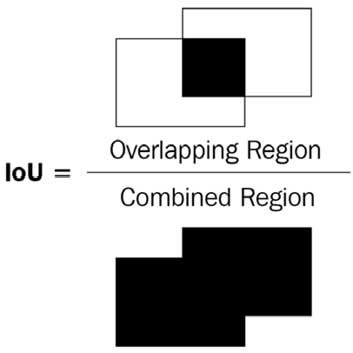

根据下图所示，我们假设左边的变成是真实边界框，右边的边框是预测边界框，我们可以直观的看到，两个边框的IoU值，以及它们的重叠关系。

图5<br>
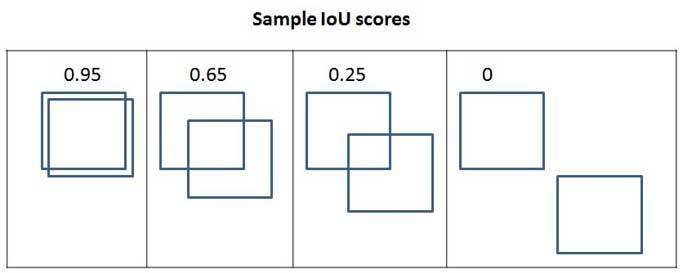

定义函数来计算交并比（IoU）：

图6<br>
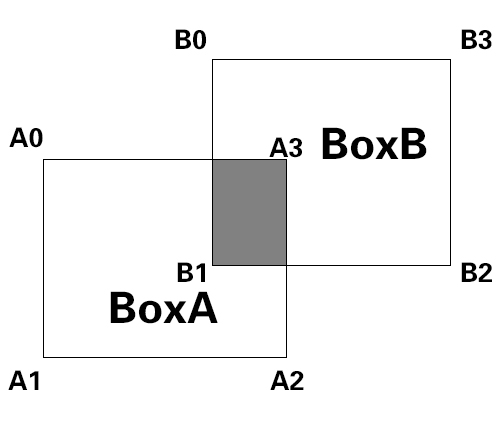

1. 定义get_iou函数，该函数接收boxA和boxB作为输入，其中boxA和boxB是两个不同的边界框（你可以将boxA视为真实边界框，将boxB视为候选区域），epsilon是一个很小的值，防止出现两个边界框的并集为0，而出现除0错误。

In [ ]:
def get_iou(boxA, boxB, epsilon=1e-5):

2. 计算交集框的坐标，x1存储两个边界框之间左端x值的最大值。类似地，y1存储顶部y值，而x2和y2分别存储对应于交集部分的右端x值和底部y值。

In [ ]:
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])

3. 计算对应于交集区域的宽度和高度

In [ ]:
    width = (x2 - x1)
    height = (y2 - y1)

4. 计算重叠区域

In [ ]:
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

请注意，这段代码表示，我们指定如果对应重叠区域的宽度或高度小于0，则交集面积为0。否则，我们像计算矩形面积一样计算重叠面积（交集）——宽度乘以高度。

5. 计算对应于两个边界框的组合面积

In [ ]:
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap

这段代码表示，我们计算了两个边界框的组合面积——area_a 和 area_b——然后在计算 area_combined 时减去了重叠面积，因为 area_overlap 在计算 area_a 和 area_b 时各计算了一次，所以被计算了两次。

6. 计算交并比（IoU）的值

In [ ]:
    iou = area_overlap / (area_combined+epsilon)
    return iou

我们已经学习了如何标注图片，以及如何计算交并比，在我们开始学习R-CNN模型之前，我们还需要学习非极大值抑制（Non-max suppression），我们使用训练好的模型预测新图片时，同一个对象可能会有多个预测框，非极大值抑制可以排除那些预测概率小的预测框（同一对象只保留预测概率最高的边界框）。

## 13.5 非极大值抑制（Non-max suppression）

使用SelectiveSearch生成候选区域时，预测的边界框彼此之间会有大量的重叠，就像刚才的图片所显示的那样。我们如何从众多的候选区域中识别出包含目标的框，并决定哪些框应该被丢弃？在这种情况下，我们需要使用非极大值抑制（Non-Maximum Suppression, NMS）。让我们来解释一下这个术语。

非极大值抑制，这个术语中，<br>
非极大值：指的是那些不是最高的边界框。<br>
抑制：指的是我们会丢弃这些边界框。<br>

非极大值抑的算法步骤如下：<br>
1. 我们使用SelectiveSearch方法，生成很多候选区域
2. 我们将生成的候选区域传入模型中进行预测
3. 将预测的概率按从高到低排列
4. 选择最高概率的边界框
5. 计算其余边界框与最高概率的边界框的交并比（重叠程度）
6. 如果与最高概率的边界框重叠较多，则丢弃这个边界框（重叠多代表同一目标，即丢弃同一目标，且概率较小的边界框）
7. 将剩下的边界框重新按照预测的概率排序，重复第3到第6步，直到计算完所有的边界框

图7<br>
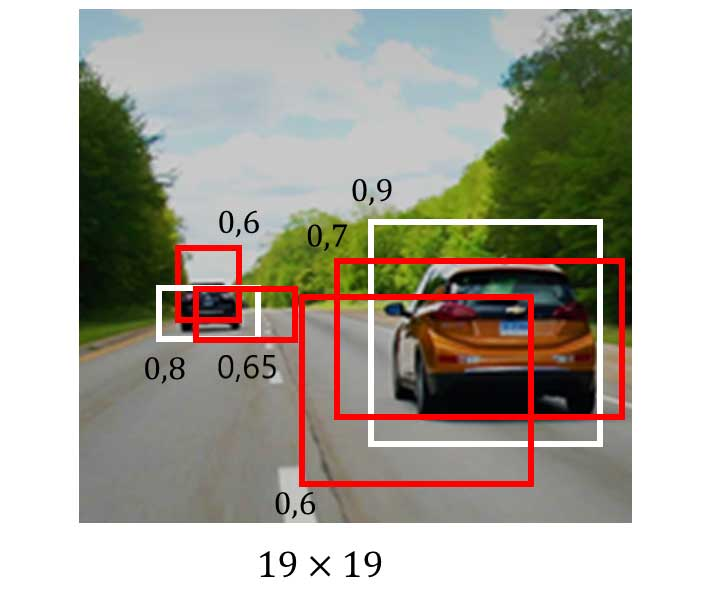

如上图所示，根据边界框的概率进行排序，预测概率为0.9的边界框排第一，如何计算其余边界框与这个预测概率第一的边界框的交并比，其中预测概率为0.7和0.6的边界框与预测概率第一的边界框交并比较大，即重叠部分较大，则保留预测概率为0.9的预测框，将预测概率较低的预测框（图中红色边界框）丢弃。然后再对剩余边界框排序，此时左边预测概率0.8的边界框排第一，重复刚才的步骤，计算剩余边界框与预测概率0.8的边界框的交并比，将重叠较大，且概率较低的边界框丢弃。重复以上步骤，直至计算完成。

## 13.6 平均精度均值（Mean average precision）

接下来，我们需要量化模型预测的准确性，我们使用平均精度均值（mAP）来衡量，我们首先理解精确度（precision），然后是平均精度（average precision），最后是mAP。

#### $精确度（precision）= \frac{正确预测位置}{正确预测位置+错误预测位置}$

正确预测位置（True Positive）指的是预测了正确类别的目标，并且与真实边界框（ground truth）的IoU（交并比）大于某个特定阈值的边界框。错误预测位置（False Positive）指的是预测类别错误或者与真实情况的重叠度低于定义阈值的边界框。此外，如果对于同一个真实情况边界框识别出多个边界框，只有一个可以是正确预测位置，其他的都是错误预测位置。

平均精度（average precision）：平均精度是在不同IoU阈值下计算出的精确度值的平均值。

平均精度均值（mAP）：是指在数据集中所有类别的对象中，根据不同的IoU（Intersection over Union）阈值计算出的平均精度均值。具体来说，mAP是通过对每个类别的AP（Average Precision）进行平均得到的，其中AP是该类别的精度值的平均值。在目标检测任务中，mAP是一个重要的性能指标，用于衡量模型对不同类别目标的检测能力。mAP值越高，表明模型在给定数据集上的整体检测效果越好
。

## 13.7 基于R-CNN的模型进行目标检测

R-CNN论文：https://arxiv.org/pdf/1311.2524

R-CNN（基于区域的卷积神经网络模型，region-based convolutional neural network）是一种用于目标检测的经典深度学习算法。它的核心思想是将目标检测任务分解为两个步骤：**候选区域生成**和**分类回归**。RCNN首先利用选择性搜索算法生成一组潜在的候选区域，然后将每个候选区域调整到固定大小并输入卷积神经网络提取特征。接着，用分类器判断区域是否属于某个目标类别，回归器则精细化目标边界框。虽然RCNN在目标检测上取得了显著进步，但其候选区域处理和逐一分类的方式导致计算效率较低。

R-CNN算法的计算过程如下图所示

图8<br>
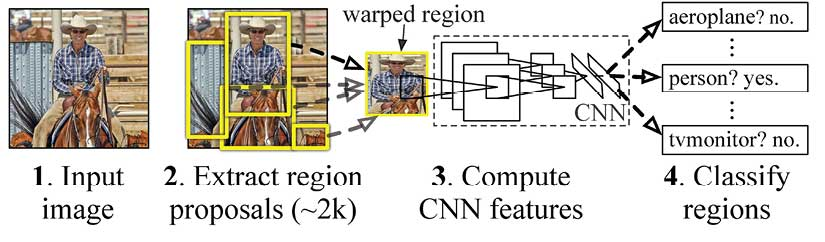

**重点**：RCNN模型详细的训练过程：
1. 用于训练的数据集中包含有对象的类别和真实边界框
2. 使用SelectiveSearch算法，生成候选区域，生成的候选区域要足够多，以免漏掉某些对象
3. 将候选区域与每一个真实边界框计算交并比（IoU）
4. 将候选区域的类别指定为，IoU最大且大于一个阈值的真实框的类别，并计算候选区域与给真实框的偏移量
5. 使用非极大值抑制，丢弃重叠的边界框，只保留置信度最大的边界框
6. 将候选区域尺寸调整为224*224，然后传入预训练模型（VGG16），然后通过全连接层输出为预测类别和预测偏移量
7. 将输出的预测类别和预测偏移量与第4步产生的类别和偏移量计算损失值
8. 通过梯度下降，调整模型参数，直到训练完成

## 13.8 在自定义数据集上实现R-CNN进行目标检测

实现R-CNN进行目标检测，包含如下步骤：<br>
1. 准备数据集
2. 对数据进行预处理
3. 定义生成候选区域和计算交并比(IoU)的函数
4. 创建训练的数据集
5. 创建用于训练的输入数据
6. 调整候选区域的尺寸
7. 将数据输入预训练的模型，并或者全连接层的值
8. 创建输出数据
9. 标记候选区域的类别或背景标签
10. 定义候选区域的与真实边界框的偏移值
11. 定义并训练模型
12. 预测新的图片

### 13.8.1 准备数据集

我们使用的数据集为：https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks<br>
在kaggle环境中，将数据集添加到书签，然后在Notebook的input中添加数据集，即可使用。<br>
在本地环境使用kaggle数据集可以参考：https://cv.kedaya.online/article/using-kaggle-datasets-locally/

In [ ]:
#导入相应的库
%pip install -q --upgrade selectivesearch torch_snippets
import os
import matplotlib.pyplot as plt
import selectivesearch
import numpy as np
import pandas as pd
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
import torch.nn as nn
from torch import optim
from torchvision.ops import nms
%matplotlib inline
import time

import warnings
warnings.filterwarnings('ignore')

start_time = time.time()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 13.8.2 准备数据

数据集下载完毕之后，我们需要准备数据集，包含以下步骤：<br>
1. 获取每张图片及其对应的类别和边界框值。
2. 获取每张图片内的候选区域（region proposals），它们对应的交并比（IoU），以及候选区域相对于真实边界框需要被校正的delta值。
3. 为每个类别分配数字标签（除了公交车和卡车类别外，我们还有一个额外的背景类别，其中与真实边界框的交并比低于一个阈值）。
4. 将每个区域提议调整到一个共同的大小，以便将它们传递给神经网络。

#### 13.8.2.1 指定图片文件目录和图片标注文件df.csv路径

In [ ]:
IMAGE_ROOT = '/kaggle/input/open-images-bus-trucks/images'
DF_RAW = pd.read_csv('/kaggle/input/open-images-bus-trucks/df.csv')
print(DF_RAW.head())

XMin, XMax, YMin, YMax是真实边界框的坐标，LabelName是图像的类别标签

#### 13.8.2.2 定义一个类，该类返回图像及其对应的类别和真实边框，以及图像文件的路径：<br>
__init__：将df和图片文件路径作为初始化方法（__init__）的参数，获取唯一的图片ID，因为一张图片可能包含多个对象，所有df数据表中可能出现重复的图片ID，图片ID和图片文件名是一样的，我们可以通过图片ID来读取文件。
__getitem__：根据索引[ix]，来获取图片ID，最终返回图片对象，边界框，边界框对应的类，以及图片的文件路径

In [ ]:
class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = r"" + os.path.join(self.root, f'{image_id}.jpg')
        image = cv2.imread(image_path, 1)[...,::-1] # conver BGR to RGB
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path

#### 13.8.2.3 检查图片的类及边界框是否正确

定义函数，用于显示图片及边界框

In [ ]:
def show_image(img, bbs=None, texts=None, sz=10, title='Original image'):
    # 创建图像和坐标轴
    _, ax = plt.subplots(1, 1, figsize=(sz, sz))
    
    # 显示图像
    ax.imshow(img)
    
    # 如果有 bounding boxes 和 texts，则绘制它们
    if bbs is not None and texts is not None:
        for bb, text in zip(bbs, texts):
            x, y, X, Y = bb
            # 绘制矩形框
            ax.add_patch(plt.Rectangle((x, y), X - x, Y - y, edgecolor='#00ff00', facecolor='none', lw=5))
            # 显示文本
            ax.text(x, y, text, color='blue', fontsize=12, backgroundcolor='white')
    
    # 设置标题并关闭坐标轴
    ax.set_title(title)
    ax.axis('off')
    plt.show()

检测图片分类及边界框

In [ ]:
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[9]
show(im, bbs=bbs, texts=clss, sz=10)

#### 13.8.2.4 定义extract_iou和extract_candidates函数来计算交并比和生成候选区域

In [ ]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates
    
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

### 13.8.3 获取候选区域及边界框的偏移量

#### 13.8.3.1 我们使用selectivesearch算法来生成候选区域，如果候选区域包含对象，则输出候选区域的对象类别，与该候选区域重叠最多（IoU最大）的边界框的偏移量。<br>
初始化FPATHS空列表，来保存图片路径。<br>
初始化GTBBS空列表，来保存真实边界框。<br>
初始化CLSS空列表，来保存图片包含的类。<br>
初始化DELTAS空列表，来保存与该候选区域重叠最多的边界框的偏移量。<br>
初始化ROIS空列表，来保存候选区域的坐标。<br>
初始化IOUS空列表，来保存候选区域与真实边界框的交并比。<br>

In [ ]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []

#### 13.8.3.2 计算FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS的值，并填充到列表

1. 为了减小训练时间，我们只使用前500张图片进行训练：

In [ ]:
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break

2. 获取候选区域，df中的坐标的值为XMin, Xmax, YMin, YMax，而生成的候选区域的坐标的值为x,y,w,h，我们需要将候选区域的坐标转化为与df中的一致，

In [ ]:
    H, W, _ = im.shape
    #获取每张图片的候选区域
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])

3. 初始化空列表ious, rois, deltas, clss来保存数据：<br>
ious：每个候选区域与每个真实边界框的IoU
rois：图片的所有候选区域
deltas：每个候选区域与重叠最大的真实边界框的偏移量（重叠部分大于0.3）
clss：与每个候选区域重叠最大的真实边界框的分类（重叠部分大于0.3，否则分类为背景“background”）

In [ ]:
    ious, rois, clss, deltas = [], [], [], []

4. 保存每个候选区域与每个真实边界框的交并比

In [ ]:
    #计算每个候选区域与每个真实边界框的IoU
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T

5. 保存每个候选区域的坐标，用于后面计算交并比

In [ ]:
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate

6. 获取候选区域与每个真实边界框的交并比

In [ ]:
        #（遍历）每个候选区域对应所有真实边框的IoU
        candidate_ious = ious[jx]

7. 找到候选区域对应真实边界框的最大值的索引，并根据索引获取最大交并比和对应的真实边界框的坐标

In [ ]:
        #获取候选区域对应真实边界框的最大值的索引
        best_iou_at = np.argmax(candidate_ious)
        #根据索引获取最大交并比
        best_iou = candidate_ious[best_iou_at]
        #根据索引获取真实边界框的坐标
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]

8. 如果该候选区域的最大交并比大于0.3，则将给候选区域标记为对应真实边界框的对象分类，否则将其标记为背景。

In [ ]:
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')

9. 计算并保存偏移量，保存候选区域

In [ ]:
        #计算偏移量
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        #保存所有候选区域
        rois.append(candidate / np.array([W,H,W,H]))

10. 将计算的结果保存到列表中

In [ ]:
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)

11. 保存文件路径及计算得到的FPATHS, IOUS, ROIS, CLSS, DELTAS, GTBBS：

In [ ]:
FPATHS = [os.path.join(IMAGE_ROOT, os.path.splitext(f)[0] + ".jpg") for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

#### 13.8.3.3 将对象的分类从分类名改为用数值索引来代替，方便后期计算损失值（Loss）

In [ ]:
#定义一个函数，将二维列表展开成一维
def flatten(lists):
    return [y for x in lists for y in x]
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

#### 13.8.4 创建用于训练的数据

通过前面的工作，我们已经可以获取图片数据，获取图片的候选区域，以及候选区域对应的分类和真实边界框，以及与候选区域重叠最大的真实边界框的偏移量。现在我们需要定义一个基于候选区域的真实边界框的数据集类，并将数据放入数据装载器（DataLoader），并将输入的数据归一化（normalize），然后修改尺寸，以保持和我们使用的预训练模型有相同的尺寸。

#### 13.8.4.1 定义一个归一化函数，VGG16预训练模型的归一化参数如下：

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

#### 13.8.4.2 定义preprocess_image函数，用于调整图片通道，将图片归一化，并绑定到设备。

In [ ]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()

定义decode函数，来获取预测的类别

In [ ]:
def decode(_y):
    _, preds = _y.max(-1)
    return preds

#### 13.8.4.3 定义一个RCNNDataset数据集类，使用前面步骤获取的值，来依次返回用于训练的数据。

In [ ]:
class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)

根据索引，获取图片对象和候选区域的图像切片（crops）。

In [ ]:
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
        return image,crops,bbs,labels,deltas,gtbbs,fpath

定义collate_fn函数来执行，调整候选区域切片尺寸，将候选区域归一化操作。

In [ ]:
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas =[],[],[],[],[]
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, \
                image_deltas, image_gt_bbs, \
                image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas

创建训练数据集和验证数据集

In [ ]:
#9/10的数据用于训练，1/10的数据用于验证
n_train = 9*len(FPATHS)//10
train_ds = RCNNDataset(FPATHS[:n_train],ROIS[:n_train],
                       CLSS[:n_train], DELTAS[:n_train],
                       GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:],
                      CLSS[n_train:], DELTAS[n_train:],
                      GTBBS[n_train:])
from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2,
                          collate_fn=train_ds.collate_fn,
                          drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2,
                         collate_fn=test_ds.collate_fn,
                         drop_last=True)

### 13.8.5 RCNN网络的架构

我们需要定义一个RCNN网络，来预测候选区域的分类和对应真实边界框的偏移值，

#### 13.8.5.1 定义一个VGG16预训练模型

In [ ]:
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False
vgg_backbone.eval().to(device)

#### 13.8.5.2 定义RCNN神经网络模型

1. 定义模型的类

In [ ]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()

2. 使用VGG16预训练模型作为骨架（backbone），self.cls_score用于预测对象的分类，self.bbox用于预测边界框的偏移量。

In [ ]:
        feature_dim = 25088
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
                          nn.Linear(feature_dim, 512),
                          nn.ReLU(),
                          nn.Linear(512, 4),
                          nn.Tanh(),
                        )

3. 定义损失函数交叉熵损失函数（CrossEntropyLoss）用于计算分类的损失值，L1Loss用于计算偏移量的损失值。

In [ ]:
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()

4. 定义一个正向传播的方法（forward），将输入的值先经过VGG16计算哪，然后通过cls_score计算对象的分类，通过bbox计算边界框偏移量

In [ ]:
    def forward(self, input):
        feat = self.backbone(input)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox

5. 定义一个函数来计算损失函数的值

In [ ]:
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != 0)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb *\
                regression_loss, detection_loss.detach(),
                regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb regression_loss, \
                   detection_loss.detach(), regression_loss

#### 13.8.5.3 定义一个函数来训练模型

1. 定义train_batch函数

In [ ]:
def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

2. 定义validate_batch函数

In [ ]:
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss,loc_loss,regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss,_deltas,loss.detach(), \
                  loc_loss, regr_loss, accs.cpu().numpy()

#### 13.8.5.4 创建模型，指定损失函数，优化器和训练轮数

In [ ]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5

训练模型，并记录数据，进行数据可视化：

In [ ]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(n_epochs):
    print(f" epoch {epoch + 1}/5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn, 
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)   
        train_epoch_losses.append(loss.item())
        train_epoch_accuracies.append(accs.mean())

    train_epoch_loss = np.mean(train_epoch_losses)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, 
                                                rcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        val_epoch_accuracies.append(accs.mean())
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)
print()
plt.figure(figsize=(10, 6))
# 创建第一个图表
plt.subplot(1, 2, 1)  # 参数表示(行数, 列数, 当前区域)
plt.plot(range(1, n_epochs+1), train_losses, 'r-')  # 'r-' 表示红色的实线
plt.title('train loss')  # 图表标题
plt.xlabel('epoch')
plt.ylabel('loss')

# 创建第二个图表
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs+1), train_accuracies, 'o-', label='train')  # 'b--' 表示蓝色的虚线
plt.plot(range(1, n_epochs+1), val_accuracies, 'o--', label='val')  # 'b--' 表示蓝色的虚线
plt.title('train_accuracies')  # 图表标题
plt.xlabel('epoch')
plt.ylabel('accuracies')
plt.legend(["train", "val"])  # 显示图例

# 调整子图间距
plt.tight_layout()

# 显示图表
plt.show()

### 13.8.6 预测新的图片

1. 定义test_predictions函数来预测新的图片
2. 遍历每一个候选区域，并调整尺寸，归一化之后，绑定到设备
3. 预测分类和偏移量
4. 获取不是背景的候选区域，并且将候选区域的坐标加上偏移量，以获得修正后的坐标
5. 使用非极大值抑制（non-max suppression）来获取拥有最大置信度的不重叠边框
6. 或者最大置信度边框的类别和边框坐标
7. 绘制图片，展示结果

In [ ]:
def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    #if len(confs) == 0 and not show_output:
    if len(confs) == 0:
        show_image(img, title='No objects detect')
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
        show_image(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], title='predicted bounding box and class')
        return (x,y,X,Y),target2label[clss[best_pred]],best_conf

#### 完整代码

In [ ]:
#完整代码
%pip install -q --upgrade selectivesearch torch_snippets
import os
import matplotlib.pyplot as plt
import selectivesearch
import numpy as np
import pandas as pd
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
import torch.nn as nn
from torch import optim
from torchvision.ops import nms
%matplotlib inline
import time

import warnings
warnings.filterwarnings('ignore')

start_time = time.time()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

IMAGE_ROOT = '/kaggle/input/open-images-bus-trucks/images/images'
DF_RAW = pd.read_csv('/kaggle/input/open-images-bus-trucks/df.csv')
print(DF_RAW.head())

class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = r"" + os.path.join(self.root, f'{image_id}.jpg')
        image = cv2.imread(image_path, 1)[...,::-1] # conver BGR to RGB
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path

# 定义函数show_image，用于显示图像
def show_image(img, bbs=None, texts=None, sz=10, title='Original image'):
    # 创建图像和坐标轴
    _, ax = plt.subplots(1, 1, figsize=(sz, sz))
    
    # 显示图像
    ax.imshow(img)
    
    # 如果有 bounding boxes 和 texts，则绘制它们
    if bbs is not None and texts is not None:
        for bb, text in zip(bbs, texts):
            x, y, X, Y = bb
            # 绘制矩形框
            ax.add_patch(plt.Rectangle((x, y), X - x, Y - y, edgecolor='#00ff00', facecolor='none', lw=5))
            # 显示文本
            ax.text(x, y, text, color='blue', fontsize=12, backgroundcolor='white')
    
    # 设置标题并关闭坐标轴
    ax.set_title(title)
    ax.axis('off')
    plt.show()

        
# 检测图片分类及边界框
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[9]
show_image(im, bbs=bbs, texts=clss, sz=10)


def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates
    
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break
    H, W, _ = im.shape
    #获取每张图片的候选区域
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    ious, rois, clss, deltas = [], [], [], []
    #计算每个候选区域与每个真实边界框的IoU
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        #（遍历）每个候选区域对应所有真实边框的IoU
        candidate_ious = ious[jx]
        #获取候选区域对应真实边界框的最大值的索引
        best_iou_at = np.argmax(candidate_ious)
        #根据索引获取最大交并比
        best_iou = candidate_ious[best_iou_at]
        #根据索引获取真实边界框的坐标
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
        #计算偏移量
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        #保存所有候选区域
        rois.append(candidate / np.array([W,H,W,H]))
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)

FPATHS = [os.path.join(IMAGE_ROOT, os.path.splitext(f)[0] + ".jpg") for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

def flatten(lists):
    return [y for x in lists for y in x]
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
    
def decode(_y):
    _, preds = _y.max(-1)
    return preds

class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
        return image, crops, bbs, labels, deltas, gtbbs, fpath
        
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas

n_train = 9*len(FPATHS)//10
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False
vgg_backbone.eval().to(device)

class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25088
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
    def forward(self, input):
        feat = self.backbone(input)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != 0)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5

train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(n_epochs):
    print(f" epoch {epoch + 1}/5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn, 
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)   

        train_epoch_losses.append(loss.item())
        train_epoch_accuracies.append(accs.mean())

    train_epoch_loss = np.mean(train_epoch_losses)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, 
                                                rcnn, criterion)
        pos = (epoch + (ix+1)/_n)

        val_epoch_accuracies.append(accs.mean())
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)
print()
plt.figure(figsize=(10, 6))
# 创建第一个图表
plt.subplot(1, 2, 1)  # 参数表示(行数, 列数, 当前区域)
plt.plot(range(1, n_epochs+1), train_losses, 'r-')  # 'r-' 表示红色的实线
plt.title('train loss')  # 图表标题
plt.xlabel('epoch')
plt.ylabel('loss')

# 创建第二个图表
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs+1), train_accuracies, 'o-', label='train')  # 'b--' 表示蓝色的虚线
plt.plot(range(1, n_epochs+1), val_accuracies, 'o--', label='val')  # 'b--' 表示蓝色的虚线
plt.title('train_accuracies')  # 图表标题
plt.xlabel('epoch')
plt.ylabel('accuracies')
plt.legend(["train", "val"])  # 显示图例

# 调整子图间距
plt.tight_layout()

# 显示图表
plt.show()

def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    #if len(confs) == 0 and not show_output:
    if len(confs) == 0:
        show_image(img, title='No objects detect')
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
        show_image(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], title='predicted bounding box and class')
        return (x,y,X,Y),target2label[clss[best_pred]],best_conf

image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[7]
test_predictions(fpath)

# 记录程序结束时间
end_time = time.time()

# 计算并打印耗时
elapsed_time = end_time - start_time
print(f"程序运行时间: {elapsed_time} 秒")

In [ ]:
#验证模型
fn = '/kaggle/input/open-images-bus-trucks/images/images/001bdbbf7a3ac993.jpg'
test_predictions(fn)